## LOADING AND INSPECTING THE DATA

In [12]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor

In [13]:
# Load data
train_df = pd.read_excel("../data/raw/train(1).xlsx")
test_df  = pd.read_excel("../data/raw/test2.xlsx")

# Basic info
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

train_df.head()

Train shape: (16209, 21)
Test shape: (5404, 20)


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,9117000170,20150505T000000,268643,4,2.25,1810,9240,2.0,0,0,...,7,1810,0,1961,0,98055,47.4362,-122.187,1660,9240
1,6700390210,20140708T000000,245000,3,2.50,1600,2788,2.0,0,0,...,7,1600,0,1992,0,98031,47.4034,-122.187,1720,3605
2,7212660540,20150115T000000,200000,4,2.50,1720,8638,2.0,0,0,...,8,1720,0,1994,0,98003,47.2704,-122.313,1870,7455
3,8562780200,20150427T000000,352499,2,2.25,1240,705,2.0,0,0,...,7,1150,90,2009,0,98027,47.5321,-122.073,1240,750
4,7760400350,20141205T000000,232000,3,2.00,1280,13356,1.0,0,0,...,7,1280,0,1994,0,98042,47.3715,-122.074,1590,8071


In [14]:
train_df.shape
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16209 entries, 0 to 16208
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             16209 non-null  int64  
 1   date           16209 non-null  object 
 2   price          16209 non-null  int64  
 3   bedrooms       16209 non-null  int64  
 4   bathrooms      16209 non-null  float64
 5   sqft_living    16209 non-null  int64  
 6   sqft_lot       16209 non-null  int64  
 7   floors         16209 non-null  float64
 8   waterfront     16209 non-null  int64  
 9   view           16209 non-null  int64  
 10  condition      16209 non-null  int64  
 11  grade          16209 non-null  int64  
 12  sqft_above     16209 non-null  int64  
 13  sqft_basement  16209 non-null  int64  
 14  yr_built       16209 non-null  int64  
 15  yr_renovated   16209 non-null  int64  
 16  zipcode        16209 non-null  int64  
 17  lat            16209 non-null  float64
 18  long  

### Checking for duplicates

In [15]:
# Check
train_df.duplicated().sum()
train_df["id"].duplicated().sum()

np.int64(99)

In [16]:
# Fix
df = train_df.drop_duplicates(subset="id", keep="first")

## Understand the Target (Price)

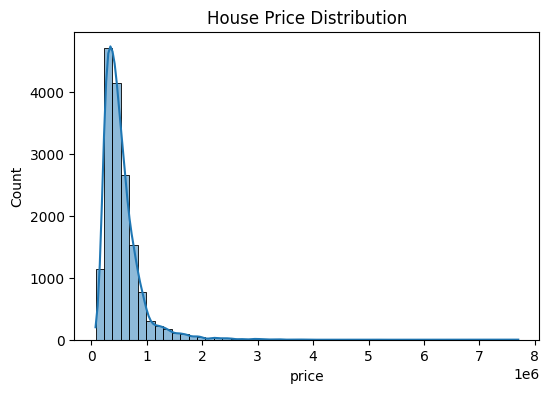

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
sns.histplot(df['price'], bins=50, kde=True)
plt.title("House Price Distribution")
plt.show()

Housing prices are right-skewed; log transformation improves normality and model convergence.

## Basic Data Cleaning

In [18]:
# Drop ID from features
X = df.drop(columns=['price', 'id'])
y = df['price']
y = np.log1p(y)

# Check missing values
X.isnull().sum().sort_values(ascending=False).head()

date           0
bedrooms       0
bathrooms      0
sqft_living    0
sqft_lot       0
dtype: int64

Since no column has missing value, we aren't going to change anything. Moreover, ID is just an identifier — not useful for prediction.

In [19]:
X.dtypes[X.dtypes == 'object']

date    object
dtype: object

In [20]:
X = X.drop(columns=['date'])
test_df = test_df.drop(columns=['date'])

## Feature–Target Relationship (Quick EDA)

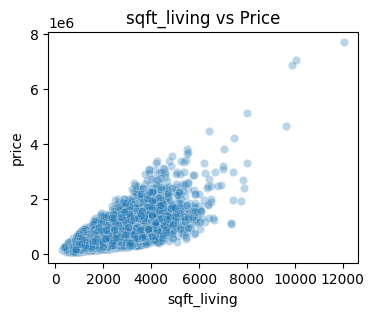

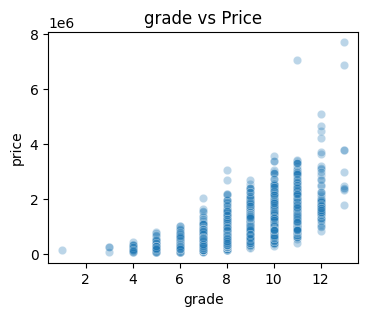

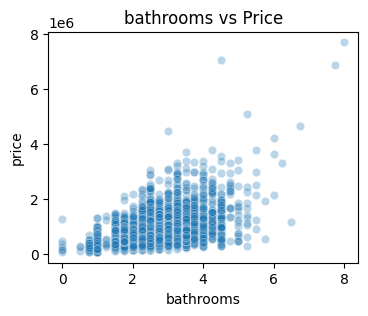

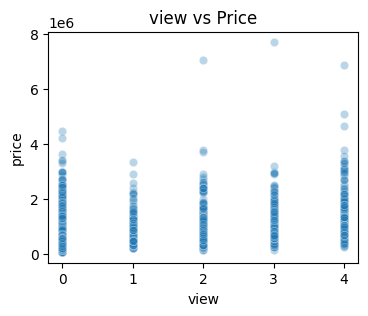

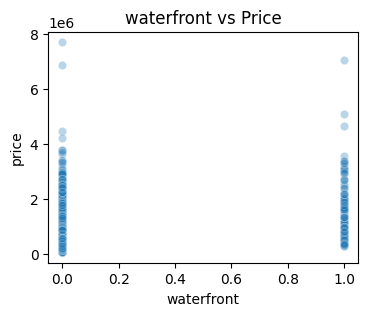

In [21]:
key_features = ['sqft_living', 'grade', 'bathrooms', 'view', 'waterfront']

for col in key_features:
    plt.figure(figsize=(4,3))
    sns.scatterplot(x=df[col], y=df['price'], alpha=0.3)
    plt.title(f"{col} vs Price")
    plt.show()

### Quick Feature Engineering

In [22]:
X["house_density"] = X["sqft_living"] / X["sqft_lot"]

We also designed X["price_per_sqft"] = np.expm1(y) / X["sqft_living"] in feature engineering but didn't use it because it was leading to data leakage and r2 score reached >0.9, probably showing overfitting.

## Baseline ML Model

#### Train–Validation Split

In [33]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [34]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

#### Model 1: Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

y_pred = lr.predict(X_val_scaled)

# Inverse transform
y_val_original = np.exp(y_val)
y_pred_original = np.exp(y_pred)

# Computing RMSE in original units
rmse_original = np.sqrt(mean_squared_error(y_val_original, y_pred_original))
r2_original = r2_score(y_val_original, y_pred_original)

print("Linear Regression RMSE:", rmse_original)
print("Linear Regression R2:", r2_original)

Linear Regression RMSE: 185969.5730175555
Linear Regression R2: 0.7170791951210223


#### Model 2: Ridge Regression

In [39]:
ridge = Ridge(alpha=1.0)
ridge.fit(X_train_scaled, y_train)

pred_ridge = ridge.predict(X_val_scaled)

# Inverse transform
y_val_original = np.exp(y_val)
y_pred_original = np.exp(pred_ridge)

# Compute RMSE in original units
rmse_ridge = np.sqrt(mean_squared_error(y_val_original, y_pred_original))
r2_ridge = r2_score(y_val_original, y_pred_original)

print("Ridge Regression RMSE:", rmse_ridge)
print("Ridge Regression R2:", r2_ridge)

Ridge Regression RMSE: 185966.759560195
Ridge Regression R2: 0.7170877554417989


#### Model 3: Random Forest (Non-Linear baseline)

In [40]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=20,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)
y_pred = rf.predict(X_val)

# Inverse transform
y_val_original = np.exp(y_val)
y_pred_original = np.exp(y_pred)

# Compute RMSE in original units
rmse = np.sqrt(mean_squared_error(y_val_original, y_pred_original))
r2 = r2_score(y_val_original, y_pred_original)

print("Random Forest RMSE:", rmse)
print("Random Forest R2:", r2)

Random Forest RMSE: 125838.13962315045
Random Forest R2: 0.8704594683092302


In [28]:
train_df.to_csv("../data/processed/train_clean.csv", index=False)
test_df.to_csv("../data/processed/test_clean.csv", index=False)